In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Function to perform train-test split and complete missing data using regression
def complete_missing_data(df, target_station):
    # Drop rows with NaN values in the target station
    # Create a copy of the dropped rows
    dropped_df = df[df.isna().any(axis=1)]

    # Filtrar las filas donde target_station es NaN
    target_nan_df = df[df[target_station].isna()]

    # Filtrar las filas donde el resto de las columnas no son NaN
    target_nan_df_non_nan_other_columns_df = target_nan_df[target_nan_df.drop(columns=[target_station]).notna().all(axis=1)]

    # Obtener las filas que están en dropped_df pero no en target_nan_df_non_nan_other_columns_df
    rows_to_keep = dropped_df.index.difference(target_nan_df_non_nan_other_columns_df.index)
    dropped_df_not_in_target_nan = dropped_df.loc[rows_to_keep]

    # Drop the rows with NaN values in 'target_station' from the original DataFrame
    remaining_df = df.dropna()
    
    # Train-test split (70% train, 30% test)
    train_df, test_df = train_test_split(remaining_df, test_size=0.3, random_state=42)

    # Initialize regression models
    linear_reg = LinearRegression()
    random_forest_reg = RandomForestRegressor()

    # Define performance metric (RMSE in this example)
    def root_mean_squared_error(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    # Train models on the training set
    X_train = train_df.drop([target_station, 'Fecha'], axis=1)
    y_train = train_df[target_station]
    linear_reg.fit(X_train, y_train)
    random_forest_reg.fit(X_train, y_train)

    # Evaluate models on the test set
    X_test = test_df.drop([target_station, 'Fecha'], axis=1)
    y_test = test_df[target_station]
    linear_reg_rmse = root_mean_squared_error(y_test, linear_reg.predict(X_test))
    random_forest_rmse = root_mean_squared_error(y_test, random_forest_reg.predict(X_test))

    # Choose the best model based on performance (lower RMSE in this case)
    if linear_reg_rmse < random_forest_rmse:
        selected_model = linear_reg
        selected_model_name = 'Linear Regression'
        selected_model_rmse = linear_reg_rmse
    else:
        selected_model = random_forest_reg
        selected_model_name = 'Random Forest'
        selected_model_rmse = random_forest_rmse

    # Use the selected model to complete missing values in the target station
    feature_names = X_train.columns
    for index, row in target_nan_df_non_nan_other_columns_df.iterrows():
        if pd.isnull(row[target_station]):
            X_pred = row.drop([target_station, 'Fecha']).values.reshape(1, -1)
            X_pred_df = pd.DataFrame(X_pred, columns=feature_names)
            predicted_value = selected_model.predict(X_pred_df)[0]

            # Check if the predicted value is negative or close to 0
            if predicted_value < 0 or np.isclose(predicted_value, 0):
                predicted_value = 0
                
            target_nan_df_non_nan_other_columns_df.loc[index, target_station] = np.round(predicted_value,2)

    # Merge them back together
    merged_df = pd.concat([target_nan_df_non_nan_other_columns_df, remaining_df,dropped_df_not_in_target_nan], ignore_index=True)
    merged_df.sort_values(by='Fecha', inplace=True)
    return merged_df, selected_model_name, selected_model_rmse


In [2]:
obs=pd.read_csv('../data/precp/gauge.csv',sep=',')
#obs['Fecha'] = pd.to_datetime(obs['Fecha'], dayfirst=True)
#obs['Fecha'] = pd.to_datetime(obs['Fecha'])
#obs.set_index('Fecha',inplace=True)
obs.head()

,Fecha,chusis,chalaco,huamarca,huancabamba,miraflores
0,1980-01-01,0.0,0.0,0.4,2.1,0.0
1,1980-01-02,0.0,0.0,0.0,0.0,0.0
2,1980-01-03,0.0,0.0,0.0,1.5,0.0
3,1980-01-04,0.0,0.0,0.0,0.0,0.0
4,1980-01-05,0.0,0.0,0.0,0.0,0.0


In [3]:
# Example usage: Complete data for 'VIRREY' station and get the selected model name and RMSE
completed_df, model_name, model_rmse = complete_missing_data(obs, 'chusis')
print(f"Selected Model: {model_name}")
print(f"RMSE: {model_rmse}")
print(completed_df)

Selected Model: Linear Regression
RMSE: 3.4388010052080964
            Fecha  chusis  chalaco  huamarca  huancabamba  miraflores
1505   1980-01-01     0.0      0.0       0.4          2.1         0.0
1506   1980-01-02     0.0      0.0       0.0          0.0         0.0
1507   1980-01-03     0.0      0.0       0.0          1.5         0.0
1508   1980-01-04     0.0      0.0       0.0          0.0         0.0
1509   1980-01-05     0.0      0.0       0.0          0.0         0.0
...           ...     ...      ...       ...          ...         ...
13875  2017-12-27     NaN      NaN       2.8          NaN         0.0
13876  2017-12-28     NaN      NaN      12.2          NaN         0.2
13877  2017-12-29     NaN      NaN       2.4          NaN         0.0
13878  2017-12-30     NaN      NaN       0.2          NaN         0.0
13879  2017-12-31     0.0      NaN       4.0          0.2         NaN

[13880 rows x 6 columns]


In [4]:
nan_percentages = obs.isna().mean() * 100
# Sort columns based on NaN percentages in ascending order
ordered_columns = nan_percentages.sort_values().index.tolist()
ordered_columns.pop(0)

resultados = {}
resultados['Gauge'] = []
resultados['Selected Model'] = []
resultados['RMSE'] = []
for idx,gauge in enumerate(ordered_columns):
    if idx == 0:
        completed_df, model_name, model_rmse = complete_missing_data(obs, gauge)
    else:
        completed_df, model_name, model_rmse = complete_missing_data(completed_df, gauge)
    print(f"Selected Model: {model_name}")
    print(f"RMSE: {model_rmse}")
    print(completed_df)
    resultados['Gauge'].append(gauge)
    resultados['Selected Model'].append(model_name)
    resultados['RMSE'].append(model_rmse)
    


Selected Model: Linear Regression
RMSE: 3.4350539803427287
            Fecha  chusis  chalaco  huamarca  huancabamba  miraflores
82     1980-01-01     0.0      0.0       0.4          2.1         0.0
83     1980-01-02     0.0      0.0       0.0          0.0         0.0
84     1980-01-03     0.0      0.0       0.0          1.5         0.0
85     1980-01-04     0.0      0.0       0.0          0.0         0.0
86     1980-01-05     0.0      0.0       0.0          0.0         0.0
...           ...     ...      ...       ...          ...         ...
13875  2017-12-27     NaN      NaN       2.8          NaN         0.0
13876  2017-12-28     NaN      NaN      12.2          NaN         0.2
13877  2017-12-29     NaN      NaN       2.4          NaN         0.0
13878  2017-12-30     NaN      NaN       0.2          NaN         0.0
13879  2017-12-31     0.0      NaN       4.0          0.2         NaN

[13880 rows x 6 columns]
Selected Model: Linear Regression
RMSE: 6.347277488402611
            Fecha

In [5]:
completed_df.isna().mean() * 100

Fecha          0.000000
chusis         6.563401
chalaco        1.988473
huamarca       2.672911
huancabamba    2.759366
miraflores     5.036023
dtype: float64

In [6]:
obs.isna().mean() * 100

Fecha           0.000000
chusis         17.406340
chalaco         4.178674
huamarca        3.940922
huancabamba     3.350144
miraflores      7.536023
dtype: float64

In [7]:
pd.DataFrame(resultados)

,Gauge,Selected Model,RMSE
0,huancabamba,Linear Regression,3.435054
1,huamarca,Linear Regression,6.347277
2,chalaco,Linear Regression,5.072806
3,miraflores,Linear Regression,4.817099
4,chusis,Linear Regression,3.515940


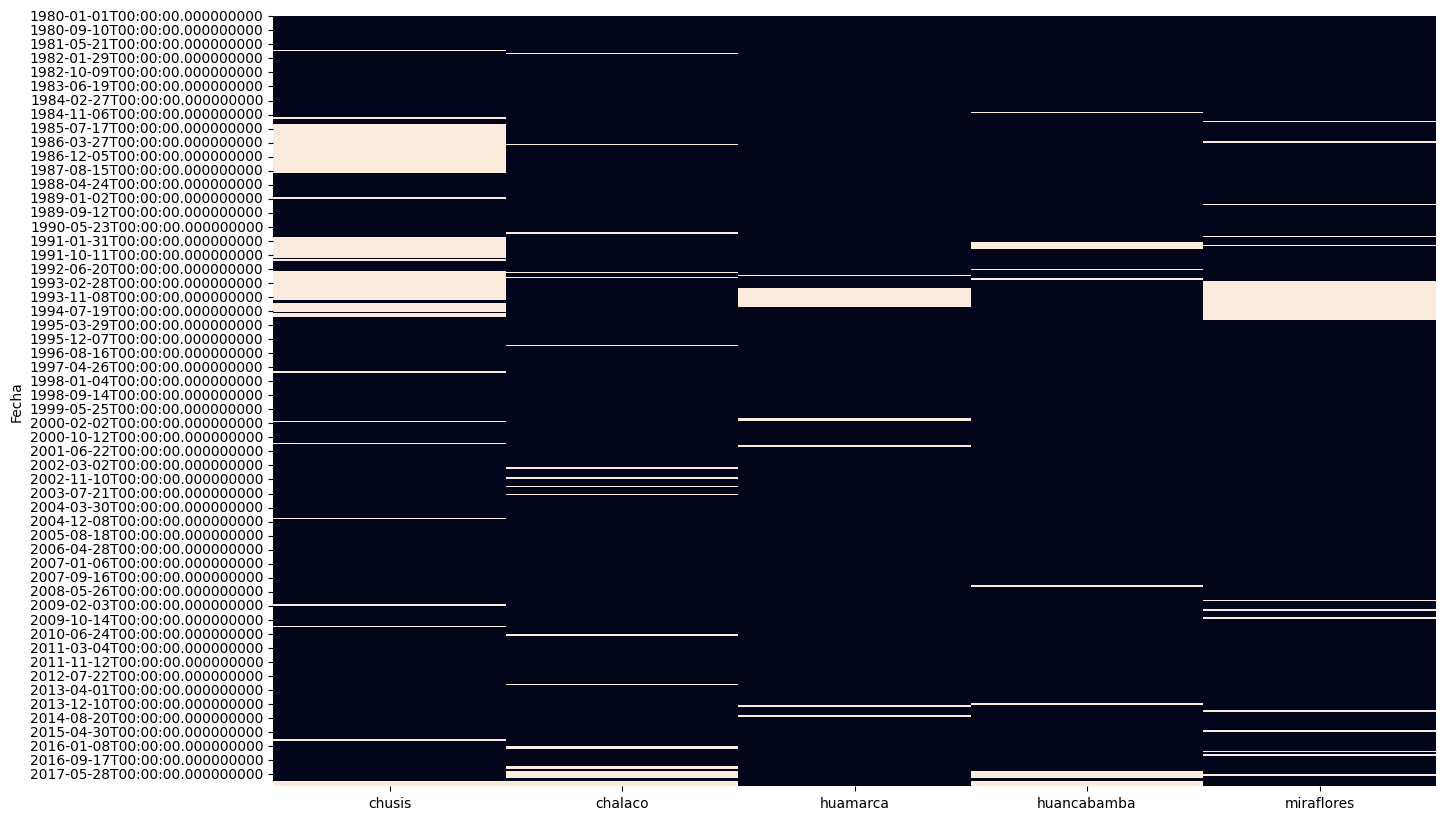

In [8]:
obs['Fecha'] = pd.to_datetime(obs['Fecha'])
obs.set_index('Fecha',inplace=True)
plt.figure(figsize=(15,10))
sns.heatmap(obs.isnull(), cbar=False)
plt.show()

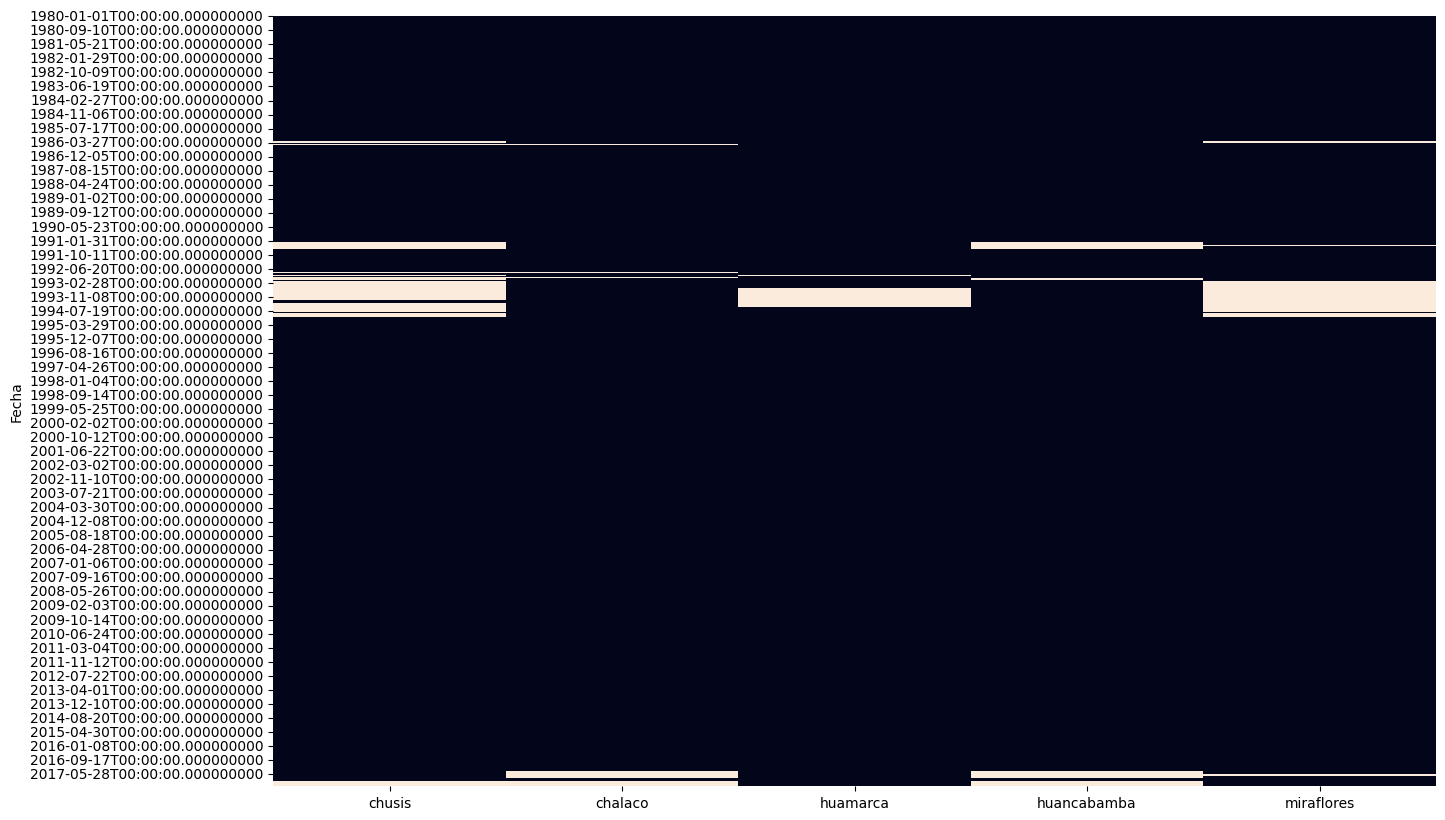

In [9]:
completed_df['Fecha'] = pd.to_datetime(completed_df['Fecha'])
completed_df.set_index('Fecha',inplace=True)
plt.figure(figsize=(15,10))
sns.heatmap(completed_df.isnull(), cbar=False)
plt.show()